***Convex Analysis of Mixture Non-negative Sourses***

В данной работе реализован алгоритм CAMNS. С помощью него разделим смешанные картинки.

Для демонстрации работы используем 3 картинки jpg, разрешения 256 * 256. Для усложнения задачи попробуем рассматривать цветные картинки, применяя алгоритм к каждому из цветов (RGB)

In [17]:
import numpy as np

from scipy import optimize

from PIL import Image

from matplotlib.pyplot import imshow

from matplotlib import pyplot as plt

from scipy import stats as sps

from scipy import linalg

import cvxpy as cp

Загрузим картинки

In [2]:
# img1 = Image.open("cao1.jpg")
# img2 = Image.open("ksiwek1.jpg")
# img3 = Image.open("zhang1.jpg")

img1 = Image.open("fox.jpg")
img2 = Image.open("cat1.jpg")
img3 = Image.open("cat2.jpg")

In [3]:
np.array(img3.getdata()).shape

(65536, 3)

In [21]:
canal = 1
img1_seq = img1.getdata()
img1_red = np.array(img1_seq)[:,0]
img1_green = np.array(img1_seq)[:,1]
img1_blue = np.array(img1_seq)[:,2]

img2_seq = img2.getdata()
img2_red = np.array(img2_seq)[:,0]
img2_green = np.array(img2_seq)[:,1]
img2_blue = np.array(img2_seq)[:,2]

img3_seq = img3.getdata()
img3_red = np.array(img3_seq)[:,0]
img3_green = np.array(img3_seq)[:,1]
img3_blue = np.array(img3_seq)[:,2]

size = int(np.sqrt(img1_blue.shape[0]))

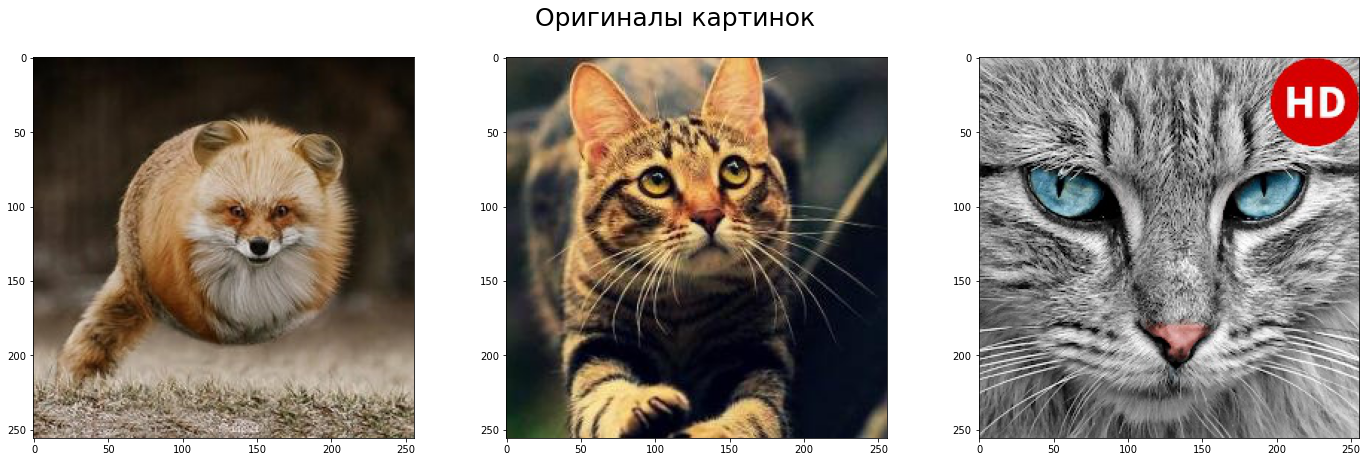

In [42]:
fig, axs = plt.subplots(1, 3, figsize=(24, 7))
plt.suptitle("Оригиналы картинок", fontsize=25)
axs[0].imshow(img1)
axs[1].imshow(img2)
axs[2].imshow(img3)
plt.show()

Разделяем на каналы цвета.

In [6]:
src_red = np.concatenate([img1_red, img2_red, img3_red]).reshape(3,-1) / 255
src_blue = np.concatenate([img1_blue, img2_blue, img3_blue]).reshape(3,-1) / 255
src_green = np.concatenate([img1_green, img2_green, img3_green]).reshape(3,-1) / 255

Создаем шум.

In [7]:
output_counter = 3
src_counter = 3
noise = sps.uniform(0,1).rvs((output_counter, src_counter))
noise = noise / (np.sum(noise, axis = 0)) 

Накладываем шум на картинки.

In [8]:
noised_src_red = (noise.T @ src_red)
noised_src_blue = (noise.T @ src_blue)
noised_src_green = (noise.T @ src_green)

noised_img1 = np.vstack([noised_src_red[0], noised_src_green[0], noised_src_blue[0]]).T
noised_img2 = np.vstack([noised_src_red[1], noised_src_green[1], noised_src_blue[1]]).T
noised_img3 = np.vstack([noised_src_red[2], noised_src_green[2], noised_src_blue[2]]).T

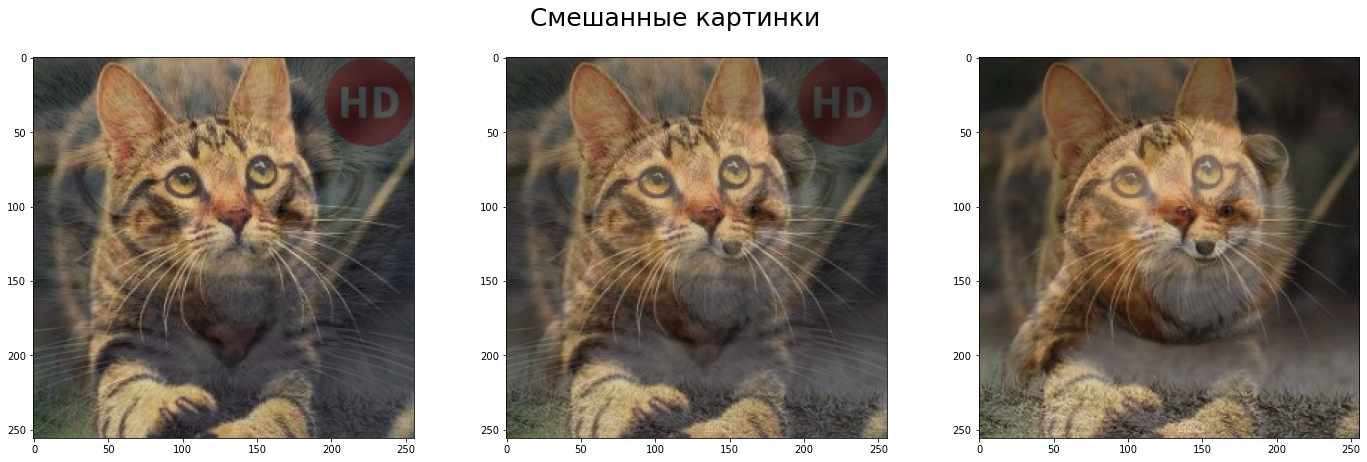

In [43]:
fig, axs = plt.subplots(1, 3, figsize=(24, 7))
plt.suptitle("Смешанные картинки", fontsize=25)
axs[0].imshow(Image.fromarray((255 * noised_img1.reshape(size, size, 3)).clip(0,255).astype(np.uint8)))
axs[1].imshow(Image.fromarray((255 * noised_img2.reshape(size, size, 3)).clip(0,255).astype(np.uint8)))
axs[2].imshow(Image.fromarray((255 * noised_img3.reshape(size, size, 3)).clip(0,255).astype(np.uint8)))
plt.show()

In [11]:
def is_ext_pt(C, d, alpha, tol):
    L, D = C.shape
    indices = np.abs(C @ alpha + d) < tol
    T = C[np.nonzero(indices)]
    if len(T) == 0:
        return False
    sin_value = np.abs(linalg.svd(T)[1])
    temp = sin_value / np.sum(sin_value)
    ran = np.sum(temp > tol)
    return ran == D

In [12]:
def CAMNS(X, N, TOL_LP=1e-3, TOL_EXT=1e-6, TOL_ZEROS=1e-6):

    Xn = X
    M = X.shape[0]
    L = X.shape[1]
    
#-----------Affine Set Fitting [Proposition 1]--------------
    d = np.sum(X, axis=0)  / M
    C, sigma, V = linalg.svd((X - d).T, full_matrices=False)
    C = C.T[:N-1].T

#--------LP Extreme-Point Finding Algorithm [Table 1]---------------
#------------Step 1
    el = 0 # the number of the extreme point estimation
    Q1 = np.zeros((L, 1))
    hS = []
    lp_cnt = 0 # the counts of the number of LPs performed
    cnt = 0
    
    while el < N: #----------Step 7 (begin)
        
#--------------Step 2
        w = sps.norm().rvs((L, 1))
        w2 = Q1.T @ w # Randomly generate a vector w
        r = w - Q1 @ w2
        
#--------------Step 3
        b = -C.T @ r
    
        #solve the min LP
        alpha1 = cp.Variable(len(b))
        objective = cp.Minimize(r.T @ (C @ alpha1 + d))
        constraints = [C @ alpha1 + d >= 0]
        prob = cp.Problem(objective, constraints)
        result = prob.solve()
        alpha1 = alpha1.value
        
        #solve the max LP
        alpha2 = cp.Variable(len(b))
        objective = cp.Maximize(r.T @ (C @ alpha2 + d))
        constraints = [C @ alpha2 + d >= 0]
        prob = cp.Problem(objective, constraints)
        result = prob.solve()
        alpha2 = alpha2.value
        
#-------------Step 4
        if el == 0:
        
            # (Modification 2) To play safe, employ the extreme point
            # validation (Lemma 6) to check the obtained optimal solutions.
            # We will reject the solution if it's not an extreme point (not commonplace by our experience).
            if is_ext_pt(C, d, alpha1, TOL_EXT):
                hS.append(C @ alpha1 + d)
                
            if is_ext_pt(C, d, alpha2, TOL_EXT):
                hS.append(C @ alpha2 + d)
                
        else:
            p_star = np.abs(r.T @ (C @ alpha1 + d))
            q_star = np.abs(r.T @ (C @ alpha2 + d))
            
            # (Modification 3) There may have some small numerical error with
            # the LP solution. Hence p_star or q_star may not be exactly zero,
            # even though they are supposed to be zero theoretically. A threshold is
            # in place to decide the acceptance/rejection of the obtained solutions.
            # Also, extreme point validation is employed just to play safe.
            if p_star / (np.linalg.norm(r) * np.linalg.norm(C @ alpha1 + d)) >= TOL_LP:
                if is_ext_pt(C, d, alpha1, TOL_EXT):
                    hS.append(C @ alpha1 + d)
            if q_star / (np.linalg.norm(r) * np.linalg.norm(C @ alpha2 + d))>= TOL_LP:
                if is_ext_pt(C, d, alpha2, TOL_EXT):
                    hS.append(C @ alpha2 + d)
                    
#------------Step 5        
        el = len(hS) # Update el to be the number of columns of hS
        if el > 0:
            Q1, R = linalg.qr(np.asarray(hS).T, mode='economic') # Apply thin QR decomposition
        cnt = cnt + 1
        
    #--------------when el>N (Modification 4)----------------
    # When the number of obtained extreme points happens to be greater than
    # the number of true sources (due to numerical errors or violation of
    # assumptions), we truncate by selecting the optimal solution at the
    # last run that yields a higher optimal value
    if el > N:
        p_s = hS.pop()
        q_s = hS.pop()
        if (q_star > p_star):
            hS.append(p_s)
        else:
            hS.append(q_s)
    return hS

Разделенные цветовые каналы.

In [13]:
cleared_red = CAMNS(noised_src_red, 3)
cleared_green = CAMNS(noised_src_green, 3)
cleared_blue = CAMNS(noised_src_blue, 3)

Собираем картинки из цветов.

In [ ]:
cleared_img1 = np.vstack([cleared_red[0], cleared_green[0], cleared_blue[0]]).T
cleared_img2 = np.vstack([cleared_red[1], cleared_green[1], cleared_blue[1]]).T
cleared_img3 = np.vstack([cleared_red[2], cleared_green[2], cleared_blue[2]]).T

Сравним полученные результаты.

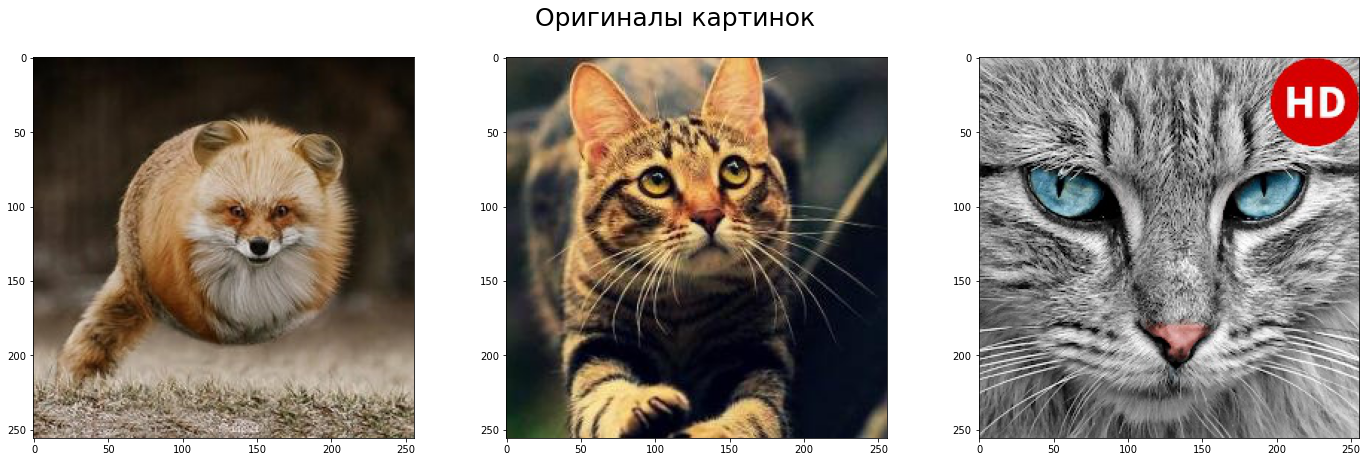

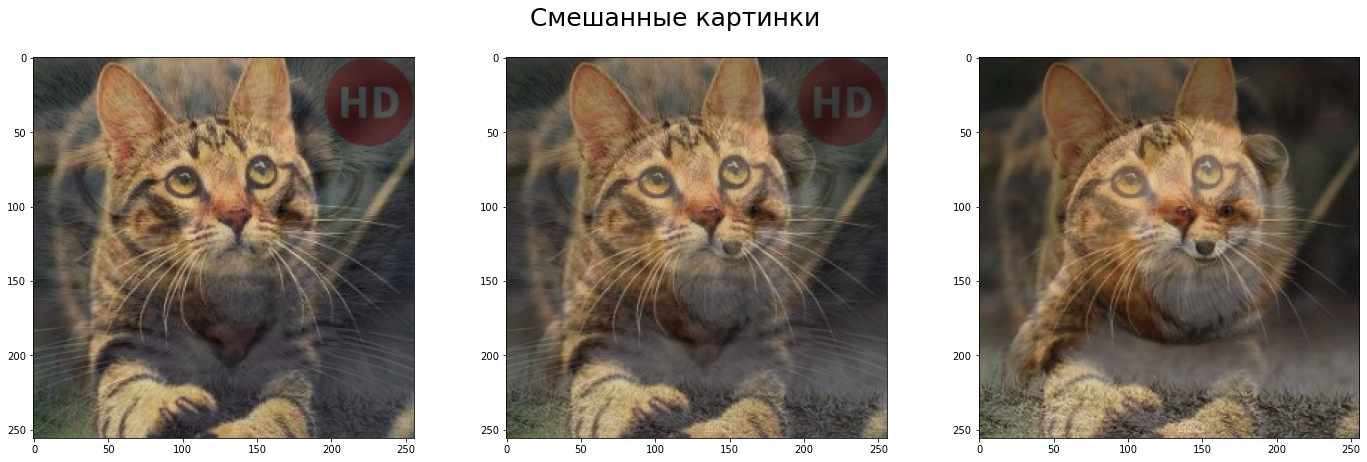

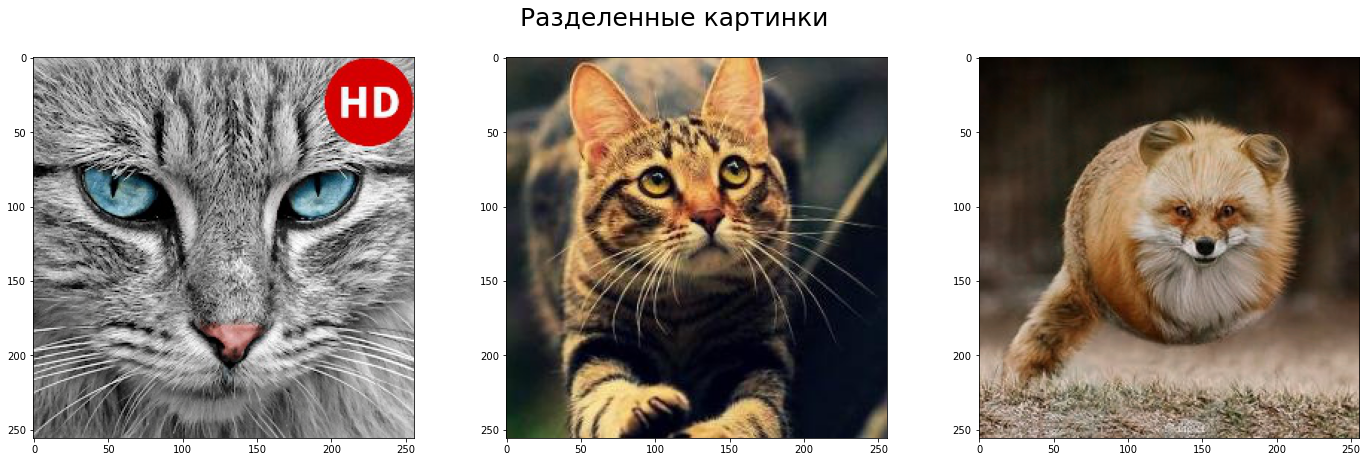

In [45]:
fig, axs = plt.subplots(1, 3, figsize=(24, 7))
plt.suptitle("Оригиналы картинок", fontsize=25)
axs[0].imshow(img1)
axs[1].imshow(img2)
axs[2].imshow(img3)
plt.show()
fig, axs = plt.subplots(1, 3, figsize=(24, 7))
plt.suptitle("Смешанные картинки", fontsize=25)
axs[0].imshow(Image.fromarray((255 * noised_img1.reshape(size, size, 3)).clip(0,255).astype(np.uint8)))
axs[1].imshow(Image.fromarray((255 * noised_img2.reshape(size, size, 3)).clip(0,255).astype(np.uint8)))
axs[2].imshow(Image.fromarray((255 * noised_img3.reshape(size, size, 3)).clip(0,255).astype(np.uint8)))
plt.show()
fig, axs = plt.subplots(1, 3, figsize=(24, 7))
plt.suptitle("Разделенные картинки", fontsize=25)
axs[0].imshow(Image.fromarray((255 * cleared_img1.reshape(size, size, 3)).clip(0,255).astype(np.uint8)))
axs[1].imshow(Image.fromarray((255 * cleared_img2.reshape(size, size, 3)).clip(0,255).astype(np.uint8)))
axs[2].imshow(Image.fromarray((255 * cleared_img3.reshape(size, size, 3)).clip(0,255).astype(np.uint8)))
plt.show()

Как мы выидим картинки разделились почти идеально.

Но у этого алгоритма существуют недостатки, а именно:
А. Алгоритм работает в следующих предположениях:
1. Неотрицательные числа (здесь проблем нет)
2. Локальное доминирование. Для каждой из картинок должен существовать индекс, где для нее в этой ячейке стоит ненулевой элемент, а для всех других нулевой.
3. Шум должен быть довольно хороший, а именно (сумма по строчкам равна 1 (по N))
4. Число зашумленных картинок, должно быть больше, или равно, чем оригиналов.
5. Мое собственное наблюдение. Алгоритм плохо работает на маленьких картинках, чем картинка больше, тем лучше работа алгоритма.

Не смотря на эти недостатки, алгоритм работает почти всегда хорошо на картинках размера даже 256 * 256 цветных, а на черно-белых еще лучше. Так же этот алгоритм можно применять в других отраслях, таких как разделение звуковых сигналов, NLP, рентгенография и многие другие.